In [27]:
import csv
import pandas as pd
import nltk
from nltk.util import pad_sequence
from nltk.util import bigrams
from nltk.util import ngrams
from nltk.util import everygrams
from nltk.lm.preprocessing import pad_both_ends
from nltk.lm.preprocessing import flatten


nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AEL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AEL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
dataset = pd.read_csv("space_explore_bear.csv")
dataset.head(5)


,text
0,a group of colorful fish on a beige background
1,a painting of a group of fish swimming together
2,a painting of a fish swimming in the ocean
3,a painting of a group of fish swimming in the ...
4,a bunch of fish that are on some rocks


In [29]:

category=[]

col=["red","black","blue","yellow","green","orange"]
colo=[]
for j in range(6):
    for i in range(300):
        category.append(j)
        colo.append(col[j])

dataset["category"]=category

dataset.head()

,text,category
0,a group of colorful fish on a beige background,0
1,a painting of a group of fish swimming together,0
2,a painting of a fish swimming in the ocean,0
3,a painting of a group of fish swimming in the ...,0
4,a bunch of fish that are on some rocks,0


In [30]:
import spacy
import numpy as np
import csv
from sklearn import linear_model
import matplotlib.pyplot as plt

stop_words = set(nltk.corpus.stopwords.words('english'))

nlp = spacy.load('en_core_web_lg')

def our_tokenizer(sentence):
    ps = nltk.stem.PorterStemmer()
    sentence = sentence.replace(',','')
    sentence = sentence.replace('.','')
    words = nltk.word_tokenize(sentence)
    

    temps = []
    for w in words: 
        if w not in stop_words: 
            temps.append(w) 

    res = []
    for stem in temps:
        res.append(ps.stem(stem))

    return res


def embedding_sim(token1, token2):
    avg=0
    for token in token1:
        max=-2
        for t in token2:
            if nlp(token).similarity(nlp(t))>max : max= nlp(token).similarity(nlp(t))
        avg+=max
    avg=float(avg/len(token1))

    return avg

def embedding_vector(token):
    sent=""
    for t in token:
        sent+=" "+t

    return nlp(sent)


vectors=[]
for i,row in dataset.iterrows():
    vectors.append(embedding_vector(our_tokenizer(row["text"])).vector)

In [31]:
dataset["vector"]=vectors

In [32]:
from sklearn.manifold import TSNE

c:\Users\AEL\anaconda3\envs\clip\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\AEL\anaconda3\envs\clip\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



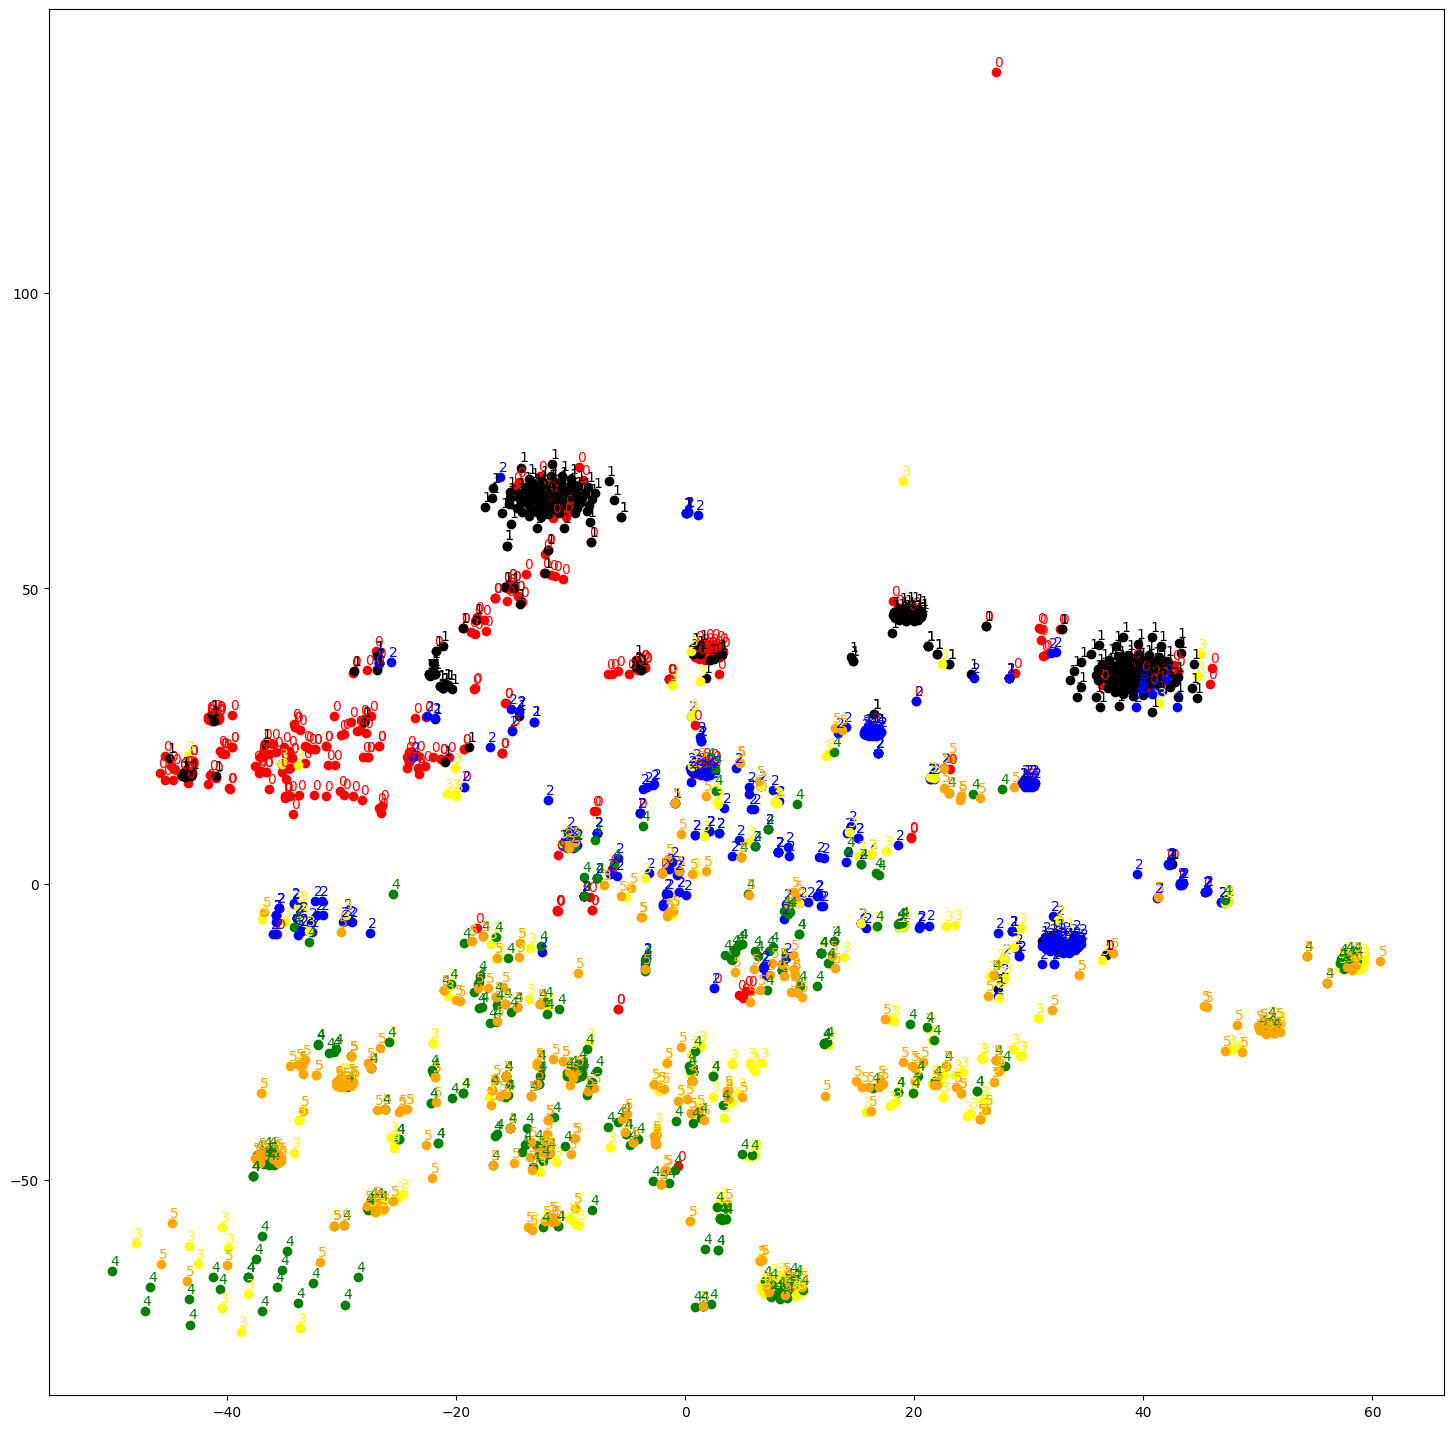

In [33]:

"""
Function to plot the words using t-SNE from the models vocabulary and the probability associations.
:param word2vec_model: Word2Vec Model.
"""

labels = list()
sentences = dataset["vector"]



tsne_model = TSNE(perplexity=25, n_components=2, n_iter=2000, random_state=0)
new_values = tsne_model.fit_transform(np.asarray(vectors))

x, y = list(), list()

for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(18, 18))

for i in range(len(x)):
    plt.scatter(x[i], y[i], c=colo[i])
    plt.annotate(category[i],
                    xy=(x[i], y[i]),
                    xytext=(5, 2),
                    textcoords="offset points",
                    color=colo[i],
                    ha="right",
                    va="bottom")
plt.savefig("./tsne_plot_word2vec.png")
plt.show(True)

In [34]:
from numpy import dot
from numpy.linalg import norm

import plotly.express as px
prompt=["fish and animal","fish and animals in water","salmon and animals in water","salmon and bears in water","salmon and bears in hot springs","Salmon and bears in hot springs in summer"]

for j in range(6):
    average =  np.zeros(shape=(300))
    for i in range(300):
        average+=vectors[j*300+i]

    average/=300

    cos_sim=[]
    for i in range(300):
        cos_sim.append( dot(average, vectors[j*300+i])/(norm(average)*norm(vectors[j*300+i])))

    fig = px.histogram(
        cos_sim,
        range_x=[.3,1],
        range_y=[0,210]
        )
    fig.update_layout(
        title=prompt[j],
        width=800,
        height=400,  # Added parameter
    )
    fig.update_traces(xbins=dict( # bins used for histogram
        start=0.3,
        end=1.0,
        size=.02
    ))
    fig.show()


In [8]:
for_variance=[]


for j in range(6):
    average =  np.zeros(shape=(300))
    for i in range(300):
        average+=vectors[j*300+i]

    average/=300

    cos_sim=[]
    for i in range(300):
        cos_sim.append( dot(average, vectors[j*300+i])/(norm(average)*norm(vectors[j*300+i])))
    
    for_variance.append(cos_sim)

In [9]:
from scipy.stats import levene

for i in range(6):
    for j in range(i+1,6):
        stat, p = levene(for_variance[i],for_variance[j])
        if(p<0.05):
            print(prompt[i],":",np.var(for_variance[i]))
            print(prompt[j],":",np.var(for_variance[j]))
            print("p-value:",p)
            print("\n")

fish and animal : 0.002573791810662042
salmon and animals in water : 0.00490867182669619
p-value: 0.0033745995009749554


fish and animal : 0.002573791810662042
salmon and bears in water : 0.004032616983448935
p-value: 0.014312231147403768


fish and animal : 0.002573791810662042
salmon and bears in hot springs : 0.007538622943446634
p-value: 9.219881151493423e-11


fish and animal : 0.002573791810662042
Salmon and bears in hot springs in summer : 0.005516239042852056
p-value: 1.5665865675564166e-07


fish and animals in water : 0.005191801769595384
salmon and bears in hot springs : 0.007538622943446634
p-value: 4.535531867789185e-06


fish and animals in water : 0.005191801769595384
Salmon and bears in hot springs in summer : 0.005516239042852056
p-value: 0.0009720777287408036


salmon and animals in water : 0.00490867182669619
salmon and bears in hot springs : 0.007538622943446634
p-value: 0.0005941256949812817


salmon and bears in water : 0.004032616983448935
salmon and bears in ho

In [35]:
quality=["bear_3_3.jpg",
"bear_3_15.jpg",
"bear_3_76.jpg",
"bear_4_97.jpg",
"bear_4_118.jpg",
"bear_4_213.jpg",
"bear_4_259.jpg",
"bear_4_283.jpg",
"bear_4_288.jpg",
"bear_4_294.jpg",
"bear_5_3.jpg",
"bear_5_4.jpg",
"bear_5_23.jpg",
"bear_5_27.jpg",
"bear_5_35.jpg",
"bear_5_53.jpg",
"bear_5_56.jpg",
"bear_5_60.jpg",
"bear_5_62.jpg",
"bear_5_78.jpg",
"bear_5_157.jpg",
"bear_5_180.jpg",
"bear_5_184.jpg",
"bear_5_234.jpg",
"bear_5_232.jpg"]

In [36]:
target=np.zeros(shape=(300))

for i in quality:
    i=i.split("_")
    i[2]=i[2].split(".")[0]
    target+=vectors[int(i[1])*300+int(i[2])]

target/=len(quality)


In [37]:
from numpy import dot
from numpy.linalg import norm

import plotly.express as px
prompt=["fish and animal","fish and animals in water","salmon and animals in water","salmon and bears in water","salmon and bears in hot springs","Salmon and bears in hot springs in summer"]

for j in range(6):
    average =  target
    cos_sim=[]
    for i in range(300):
        cos_sim.append( dot(average, vectors[j*300+i])/(norm(average)*norm(vectors[j*300+i])))

    fig = px.histogram(
        cos_sim,
        range_x=[.3,1],
        range_y=[0,110]
        )
    fig.update_layout(
        title=prompt[j],
        width=800,
        height=400,  # Added parameter
    )
    fig.update_traces(xbins=dict( # bins used for histogram
        start=0.3,
        end=1.0,
        size=.02
    ))
    fig.show()


In [26]:
for_variance=[]


for j in range(6):
    average = target

    cos_sim=[]
    for i in range(300):
        cos_sim.append( dot(average, vectors[j*300+i])/(norm(average)*norm(vectors[j*300+i])))
    
    for_variance.append(cos_sim)
from scipy.stats import levene

for i in range(6):
    for j in range(i+1,6):
        stat, p = levene(for_variance[i],for_variance[j])
        if(p<0.05):
            print(prompt[i],":",np.var(for_variance[i]))
            print(prompt[j],":",np.var(for_variance[j]))
            print("p-value:",p)
            print("\n")

fish and animal : 0.0024107341901082936
salmon and animals in water : 0.0053637432756309415
p-value: 0.0013670137954586048


fish and animal : 0.0024107341901082936
salmon and bears in water : 0.008703776319398478
p-value: 6.904108926423992e-17


fish and animal : 0.0024107341901082936
salmon and bears in hot springs : 0.009382757218124184
p-value: 2.0894012272698286e-13


fish and animal : 0.0024107341901082936
Salmon and bears in hot springs in summer : 0.00725847175221271
p-value: 3.750721044372429e-11


fish and animals in water : 0.0022188783294550454
salmon and animals in water : 0.0053637432756309415
p-value: 7.904075564856594e-05


fish and animals in water : 0.0022188783294550454
salmon and bears in water : 0.008703776319398478
p-value: 2.365110763169639e-18


fish and animals in water : 0.0022188783294550454
salmon and bears in hot springs : 0.009382757218124184
p-value: 6.995082405170094e-15


fish and animals in water : 0.0022188783294550454
Salmon and bears in hot springs 